In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 100)

In [21]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# User Latent Features

In [23]:
user_factors = pd.read_csv('data/user_factors.csv')

In [24]:
user_factors.head()

,id,features
0,640,"[0.5853673219680786, 1.1955639123916626, 0.495..."
1,650,"[0.7357923984527588, 1.1214193105697632, 0.211..."
2,660,"[0.41824525594711304, 0.8636453151702881, 0.40..."
3,670,"[0.0, 0.23701752722263336, 0.10014515370130539..."
4,680,"[0.2757687568664551, 0.9952836632728577, 0.413..."


# Movie Latent Features

In [25]:
movie_factors = pd.read_csv('data/movie_factors.csv')

In [26]:
movie_factors['features'][0]

'[0.1470944583415985, 1.0527691841125488, 0.06695104390382767, 0.2533167600631714, 0.17517654597759247, 0.5150220990180969, 0.18830619752407074, 0.5612077713012695, 0.11690513044595718, 0.7164477705955505]'

# Requests Data

In [27]:
requests_df = pd.read_csv('data/requests.csv')

In [28]:
requests_df.head()

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


# Training Data

In [29]:
training = pd.read_csv('data/training.csv')

In [30]:
training.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [31]:
training['movie'].nunique()

3662

In [32]:
print('Training data statistics: ')
training.describe()

Training data statistics: 


,user,movie,rating,timestamp
count,800000.000000,800000.000000,800000.000000,8.000000e+05
mean,3403.097837,1849.257256,3.590479,9.683921e+08
std,1546.589028,1086.852485,1.120376,5.820931e+06
min,636.000000,1.000000,1.000000,9.567039e+08
25%,2035.000000,1028.000000,3.000000,9.641524e+08
50%,3507.000000,1788.000000,4.000000,9.675878e+08
75%,4695.000000,2750.000000,4.000000,9.746878e+08
max,6040.000000,3952.000000,5.000000,9.757673e+08


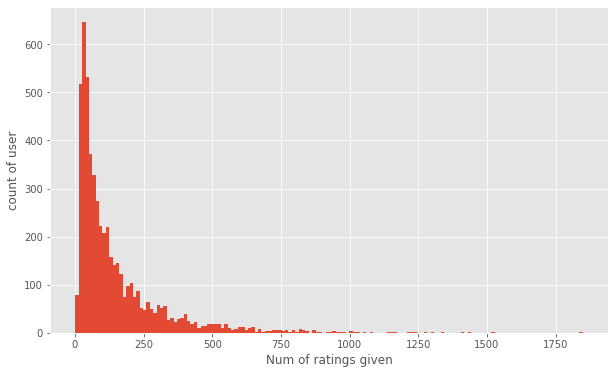

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(training.groupby('user').count()['rating'], bins=150)
ax.set_xlabel('Num of ratings given')
ax.set_ylabel('count of user');

# Movie Descriptions

In [34]:
movies = pd.read_csv('data/movies.dat', sep='::', engine='python', names=['movie_id', 'title', 'genre'])

In [35]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [44]:
movies['genre'] = movies['genre'].apply(lambda x: x.replace('|', ' '))

In [37]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [38]:
movies['genre'].unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

In [46]:
movies.set_index('movie_id', inplace=True)

In [48]:
movies_df = movies.copy().drop('title', axis=1)

In [65]:
tf = TfidfVectorizer()
movies_tfidf = tf.fit_transform(movies_df['genre'])
movies_indices = pd.Series(movies_df.index)

In [176]:
movies_sim_mat = pd.DataFrame(cosine_similarity(movies_tfidf), index=movies_indices, columns=movies_indices)

In [177]:
movies_sim_mat.to_csv('data/movies_sim_mat.csv')
movies_sim_mat.head()

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.305525,0.197372,0.260194,0.344351,0.0,0.197372,0.425153,0.0,0.00000,0.176755,0.184560,0.938841,0.000000,0.000000,0.000000,0.000000,0.0,0.344351,0.0,0.178778,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.627557,0.000000,0.000000,0.0,0.344351,0.197372,0.000000,0.000000,0.00000,0.000000,0.000000,0.260194,0.000000,0.0,0.689027,0.000000,0.0,...,0.000000,0.000000,0.344351,0.0,0.000000,0.0,0.197372,0.000000,0.344351,0.260194,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.344351,0.344351,0.0,0.344351,0.344351,0.000000,0.000000,0.184560,0.344351,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.344351,0.260194,0.801460,0.000000,0.0,0.344351,0.000000,0.000000,0.000000,0.000000
2,0.305525,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.718623,0.0,0.32089,0.000000,0.000000,0.325428,0.000000,0.319540,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.287244,0.000000,0.000000,0.000000,0.379045,0.409075,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.382454,0.000000,0.000000,0.0,0.238835,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.651211,0.000000,0.000000,0.0,0.000000,0.000000,0.287244,0.287244,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.538118,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.197372,0.000000,1.000000,0.433093,0.573172,0.0,1.000000,0.000000,0.0,0.00000,0.895543,0.307200,0.000000,0.000000,0.450274,0.000000,0.700684,0.0,0.573172,0.0,0.297576,0.000000,0.0,0.000000,0.700684,0.000000,0.000000,0.819435,0.000000,0.000000,0.000000,0.000000,0.534124,0.264266,0.700684,0.000000,0.0,0.573172,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.433093,0.700684,0.0,0.315353,0.700684,0.0,...,0.000000,0.000000,0.573172,0.0,0.000000,0.0,1.000000,0.000000,0.573172,0.433093,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.573172,0.573172,0.0,0.573172,0.573172,0.000000,0.000000,0.307200,0.573172,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.573172,0.433093,0.000000,0.000000,0.0,0.573172,0.000000,0.000000,0.000000,0.000000
4,0.260194,0.000000,0.433093,1.000000,0.755606,0.0,0.433093,0.000000,0.0,0.00000,0.679323,0.404979,0.000000,0.655026,0.000000,0.343133,0.339626,0.0,0.755606,0.0,0.687095,0.232383,0.0,0.225132,0.339626,0.655026,0.655026,0.000000,0.000000,0.655026,0.655026,0.225132,0.000000,0.610184,0.339626,0.655026,0.0,0.755606,0.433093,0.655026,0.263178,0.23294,0.655026,0.000000,1.000000,0.339626,0.0,0.000000,0.339626,0.0,...,0.655026,0.655026,0.755606,0.0,0.655026,0.0,0.433093,0.252066,0.755606,1.000000,0.0,0.655026,0.655026,0.655026,0.0,0.0,0.0,0.229773,0.755606,0.755606,0.0,0.755606,0.755606,0.000000,0.000000,0.404979,0.755606,0.0,0.0,0.0,0.0,0.0,0.0,0.343133,0.0,0.0,0.0,0.0,0.0,0.0,0.755606,1.000000,0.000000,0.262005,0.0,0.755606,0.655026,0.655026,0.655026,0.343133
5,0.344351,0.000000,0.573172,0.755606,1.000000,0.0,0.573172,0.000000,0.0,0.00000,0.513301,0.535965,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.519173,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.461059,0.000000,0.000000,0.0,1.000000,0.573172,0.000000,0.000000,0.00000,0.000000,0.000000,0.755606,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.00000

In [178]:
movies_sim_mat.iloc[2, 193]

0.8955432696358447

In [179]:
np.argsort(movies_sim_mat.iloc[2])[::-1]

movie_id
3952    2270
3951     495
3950      63
3949    2768
3948    3175
3947     841
3946    2433
3945     353
3944      67
3943    2765
3942    2175
3941     493
3940    2427
3939    3325
3938    2736
3937    1436
3936    1589
3935    2774
3934    2560
3933    3353
3932    2316
3931     925
3930     794
3929     443
3928    2441
3927    2819
3926    1529
3925    2815
3924    1245
3923    1426
        ... 
30      2274
29      2272
28      2269
27      2268
26      2267
25      2265
24      2296
23      2298
22      2342
21      2299
20      2341
19      2340
18      2335
17      2334
16      2333
15      2332
14      2331
13      2330
12      2329
11      2328
10      2325
9       2324
8       2322
7       2320
6       2317
5       2308
4       2307
3       2304
2       2301
1       1941
Name: 3, Length: 3883, dtype: int64

# User Demographics

In [39]:
users_demo = pd.read_csv('data/users.dat', sep='::', engine='python', names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])

In [40]:
users_demo.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [41]:
users_demo.describe()

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [42]:
users_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [113]:
users_demo.set_index('user_id', inplace=True)

In [185]:
users_demo.head(10)

,gender,age,occupation,zipcode
user_id,,,,
1,0,1,10,48067
2,1,56,16,70072
3,1,25,15,55117
4,1,45,7,2460
5,1,25,20,55455
6,0,50,9,55117
7,1,35,1,6810
8,1,25,12,11413
9,1,25,17,61614


In [139]:
users_indices = pd.Series(users_demo.index)

In [116]:
users_demo['gender'] = users_demo['gender'].map({'M':1, 'F':0})

In [146]:
import re

users_demo['zipcode'] = users_demo['zipcode'].str.replace('-[0-9][0-9][0-9][0-9]', '').astype(int)

In [154]:
users_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   gender      6040 non-null   int64
 1   age         6040 non-null   int64
 2   occupation  6040 non-null   int64
 3   zipcode     6040 non-null   int64
dtypes: int64(4)
memory usage: 235.9 KB


In [159]:
users_demo['zipcode'].nunique()

3403

In [170]:
testing_users = users_demo.copy().drop('zipcode', axis=1)

In [171]:
testing_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   gender      6040 non-null   int64
 1   age         6040 non-null   int64
 2   occupation  6040 non-null   int64
dtypes: int64(3)
memory usage: 188.8 KB


In [174]:
users_sim_mat = pd.DataFrame(cosine_similarity(testing_users), index=users_indices, columns=users_indices)

In [180]:
users_sim_mat.to_csv('data/users_sim_mat.csv')

In [184]:
users_sim_mat.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.368979,0.596915,0.251205,0.698953,0.274204,0.127829,0.519950,0.641451,0.127881,0.139194,0.519950,0.121556,0.099463,0.363840,0.099504,0.119357,0.261733,0.995086,0.572647,0.734804,0.712799,0.099463,0.364110,0.312529,0.363840,0.491488,0.139194,0.292599,0.292714,0.222120,0.099504,0.165432,0.099504,0.121556,0.217178,0.430660,0.312988,0.312529,0.099479,0.312988,0.397744,0.519950,0.444634,0.427101,0.790206,0.312529,0.255261,0.634062,0.178536,...,0.580070,0.312988,0.461934,0.127829,0.127881,0.099504,0.364110,0.312529,0.139194,0.444634,0.364110,0.099484,0.444730,0.597266,0.292714,0.099504,0.524067,0.312529,0.520288,0.099463,0.483256,0.483256,0.699294,0.121556,0.430660,0.121556,0.292714,0.127829,0.099424,0.397961,0.519950,0.641451,0.099424,0.519950,0.139194,0.266093,0.312529,0.312529,0.139194,0.641451,0.099504,0.251205,0.346622,0.572647,0.139194,0.597266,0.121586,0.117254,0.099504,0.328722
2,0.368979,1.000000,0.965721,0.992316,0.922391,0.994837,0.968930,0.985550,0.949497,0.968835,0.971593,0.985550,0.967390,0.961480,0.999759,0.961382,0.966833,0.993459,0.368865,0.973028,0.900970,0.914301,0.961480,0.999839,0.997541,0.999759,0.990557,0.971593,0.996672,0.996582,0.988177,0.961382,0.977665,0.961382,0.967390,0.987165,0.997592,0.998076,0.997541,0.961526,0.998076,0.999289,0.985550,0.996560,0.997849,0.860619,0.997541,0.992609,0.952061,0.980225,...,0.970993,0.998076,0.994635,0.968930,0.968835,0.961382,0.999839,0.997541,0.971593,0.996560,0.999839,0.961533,0.996419,0.965700,0.996582,0.961382,0.984896,0.997541,0.985571,0.961480,0.991961,0.991961,0.922305,0.967390,0.997592,0.967390,0.996582,0.968930,0.961300,0.999505,0.985550,0.949497,0.961300,0.985550,0.971593,0.994060,0.997541,0.997541,0.971593,0.949497,0.961382,0.992316,0.999711,0.973028,0.971593,0.965700,0.967247,0.966133,0.961382,0.998851
3,0.596915,0.965721,1.000000,0.926369,0.990997,0.934525,0.871948,0.995692,0.998391,0.871325,0.876855,0.995692,0.868748,0.857618,0.964497,0.856989,0.867611,0.929862,0.597376,0.999552,0.982710,0.988099,0.857618,0.963891,0.948591,0.964497,0.992091,0.876855,0.941779,0.941188,0.914613,0.856989,0.889836,0.856989,0.868748,0.912790,0.980497,0.948126,0.948591,0.857539,0.948126,0.973530,0.995692,0.983906,0.979727,0.963277,0.948591,0.928094,0.998799,0.895264,...,0.999186,0.948126,0.986661,0.871948,0.871325,0.856989,0.963891,0.948591,0.876855,0.983906,0.963891,0.857503,0.983405,0.999412,0.941188,0.856989,0.996074,0.948591,0.995103,0.857618,0.990806,0.990806,0.990410,0.868748,0.980497,0.868748,0.941188,0.871948,0.857674,0.973407,0.995692,0.998391,0.857674,0.995692,0.876855,0.932143,0.948591,0.948591,0.876855,0.998391,0.856989,0.926369,0.959286,0.999552,0.876855,0.999412,0.868201,0.866033,0.856989,0.953936
4,0.251205,0.992316,0.926369,1.000000,0.867663,0.999476,0.992087,0.957262,0.903545,0.991864,0.993231,0.957262,0.991292,0.988102,0.992835,0.987878,0.990994,0.999700,0.252144,0.937209,0.840629,0.857443,0.988102,0.992725,0.997415,0.992835,0.966265,0.993231,0.999055,0.998832,0.999542,0.987878,0.996154,0.987878,0.991292,0.999235,0.981533,0.997690,0.997415,0.988122,0.997690,0.987834,0.957262,0.978685,0.982274,0.791227,0.997415,0.999837,0.907251,0.996987,...,0.933960,0.997690,0.974294,0.992087,0.991864,0.987878,0.992725,0.997415,0.993231,0.978685,0.992725,0.988120,0.978440,0.926161,0.998832,0.987878,0.955992,0.997415,0.957093,0.988102,0.968780,0.968780,0.867400,0.991292,0.981533,0.991292,0.998832,0.992087,0.987966,0.987953,0.957262,0.903545,0.987966,0.957262,0.993231

In [108]:
# Setup a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert a Pandas DF to a Spark DF
spark_df = spark.createDataFrame(training) 

spark_df = spark_df.drop('timestamp')

spark_df.printSchema()

root
 |-- user: long (nullable = true)
 |-- movie: long (nullable = true)
 |-- rating: long (nullable = true)



In [109]:
train, validation = spark_df.randomSplit([0.8, 0.2], seed=111)

In [111]:
train.describe().show()

+-------+------------------+------------------+------------------+
|summary|              user|             movie|            rating|
+-------+------------------+------------------+------------------+
|  count|            639965|            639965|            639965|
|   mean|3402.1216879048075|1849.7404170540576|3.5898228809388013|
| stddev|1546.7888494485785|1086.5891041686787|1.1207273959770336|
|    min|               636|                 1|                 1|
|    max|              6040|              3952|                 5|
+-------+------------------+------------------+------------------+



In [ ]:
num_users = train.select('user').distinct().count()
num_movies = train.select('movie').distinct().count()
density = train.count() / (num_users*num_movies)
density

In [ ]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
)

recommender = als_model.fit(train)

predictions = recommender.transform(train)

predictions.describe().show()

In [ ]:
# recommender.itemFactors.show()

In [ ]:
# recommender.userFactors.show()

In [ ]:
# user1 = recommender.recommendForUserSubset(predictions, 10).where('user==700').select('recommendations').take(1)

# user1

In [ ]:
def predicted_rating(user_id, movie_id):
    try:
        user = recommender.userFactors.where(f'id == {user_id}').collect()[0]['features']
        item = recommender.itemFactors.where(f'id == {movie_id}').collect()[0]['features']
    except:
        user = 1
        item = -1
        
    return np.dot(np.array(user), np.array(item))

In [ ]:
predicted_rating(4615, 34)